Intro
=======
Pytorch ha al suo interno dei moduli per creare agevolmente delle reti neuronali e per leggere i dataset il modulo per creare le nn è **torch.nn** mentre le classi per utilizzare i dataset sono **Dataset** e **DataLoader**

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_samples = 5000

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype('float32')
y = y.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(5000, 784)


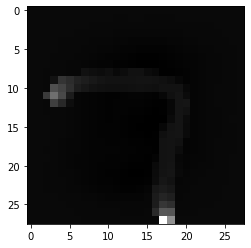

In [2]:
from matplotlib import pyplot
import numpy as np

%matplotlib inline

pyplot.imshow(X_train[0].reshape((28, 28)), cmap="gray")
print(X_train.shape)

In [3]:
print("Valore minimo {0} massimo {1}".format(y_train.min(), y_train.max()))

Valore minimo 0 massimo 9


pytorch usa come struttura base il tensore *torch.tensor* dobbiamo quindi convertire l'array numpy in un tensore

In [4]:
import torch

print("Stai usando la versione di pytorch {0}".format(torch.__version__))

Stai usando la versione di pytorch 1.4.0


In [5]:
x_train, y_train, X_test, y_test = map(
    torch.from_numpy , (X_train, y_train, X_test, y_test)
)

n, c = x_train.shape


Neural Network da zero
=======

mi vado a costruire una rete neuronale da zero senza l'uso del modulo **torch.nn** mi vado a creare i pesi con una inizializzazione random utilizzando l'inizializzaione di Xavier 

\begin{equation*}
\frac{1}{\sqrt{n}}
\end{equation*}

sia il parametro weights che il parametro bias devono avere impostato reqires_grad, questo fa si che pytorch si vada a segnare tutte le operazioni fatte sul tensore e calcolerà in automatico il gradiente nella fase di back-propagation


<div class="alert alert-block alert-info">
<b>Nota:</b> il parametro weights ha impostato requires_grad dopo l'inizializzazione in quanto non vogliamo che l'inizializzazione stessa finisca nel calcolo del gradiente
</div>

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

ci creiamo la funzione di softmax e il forward del modello, la parte di backpropagation viene fatta in automatico da pytorch

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-4.4570, -0.7388, -2.5455, -2.8431, -1.4866, -7.2059, -5.1740, -2.6367,
        -3.0171, -3.8669], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [9]:
import torch.nn.functional as F

loss_func = F.cross_entropy

nella cella superiore abbiamo usato un nuovo pezzo *torch.nn.functional* questo modulo contiene tutte le funzioni che ci servono per calcolare la funzione di costo (loss) nel nostro caso la cross_entropy

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.6896, grad_fn=<NllLossBackward>)


In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [12]:
print(accuracy(preds, yb))

tensor(0.1094)


In [13]:
from IPython.core.debugger import set_trace

lr = 0.01  # learning rate
epochs = 10  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [14]:
print(loss_func(model(X_test), y_test), accuracy(model(X_test), y_test))

tensor(nan, grad_fn=<NllLossBackward>) tensor(0.8841)


Sistemiamo il codice con nn.Module
=====

Utilizzo il modulo nn.Module per semplificare la fase di training, creo una classe che estende nn.Module e nel costruttore ```__init__``` imposto tutti i pesi su cui il modulo andrà a lavorare

In [15]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Possiamo istanziare l'oggetto appena creato

In [16]:
model = Mnist_Logistic()

Ora possiamo calcolare il costo come abbiamo fatto prima, possiamo utilizzare il modello come una funzione. Verrà chiamato il metodo forward automaticamente

In [18]:
print(loss_func(model(xb), yb))

tensor(2.8963, grad_fn=<NllLossBackward>)


prima abbiamo aggiornato i pesi uno per uno e abbiamo azzerato il gradiente a mano, ora possiamo sfruttare il modello per fare questo in maniera quasi automatica

In [21]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [22]:
fit()

In [23]:
print(loss_func(model(xb), yb))

tensor(0.1585, grad_fn=<NllLossBackward>)


nn.Linear
=====

Andiamo a semplificare ancora il modello andando ad utilizzare nn.Linear

In [24]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [25]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.4743, grad_fn=<NllLossBackward>)


In [26]:
fit()

In [27]:
print(loss_func(model(xb), yb))

tensor(0.1611, grad_fn=<NllLossBackward>)


Modulo optim
====

Pytorch ha un modulo per la gestione dell'ottimizzazione del modello invece di andare ad aggiustare i pesi a mano ci penserà l'ottimizzatore

In [30]:
from torch import optim

model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

print(loss_func(model(xb), yb))
                
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()    

print(loss_func(model(xb), yb))

tensor(2.4136, grad_fn=<NllLossBackward>)
tensor(0.1704, grad_fn=<NllLossBackward>)


Utilizziamo l'oggetto dataset
====

PyTorch ha una classe astratta Dataset. Un dataset può essere qualsiasi cosa che ha una funzione ```__len__ ``` per conoscere quanti elementi contiene e una funzione ```__getitem__``` per estrarre un elemento.

Andremo ad utilizzare TensorDataset che prende in ingresso due tensori e li combina in un unico sono.

In [32]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

In [33]:
xb,yb = train_ds[i*bs : i*bs+bs]